In [1]:
import pandas as pd
import numpy as np
df_filtered = pd.read_parquet(r"/kaggle/input/daily-crsp-df/crsp_daily_log_returns_features.parquet")


In [2]:
ewma_span = (2 / (1 - 0.94)) - 1



# 3-day returns
df_filtered['log_ret_3d'] = df_filtered.groupby('permno')['log_ret'].transform(
    lambda x: x.shift(-2) - x.shift(1)
)
df_filtered['log_mkt_ret_3d'] = df_filtered.groupby('permno')['log_mkt_ret'].transform(
    lambda x: x.shift(-2) - x.shift(1)
)

# 5-year rolling correlation
df_filtered['corr_5y'] = df_filtered.groupby('permno').apply(
    lambda group: group['log_ret_3d'].rolling(window=1260, min_periods=750).corr(group['log_mkt_ret_3d'])
).reset_index(level=0, drop=True)

# EWMA vol on 3-day returns
df_filtered['vol_1y'] = df_filtered.groupby('permno')['log_ret'].transform(
    lambda x: x.ewm(span=ewma_span, min_periods=100, adjust=True).std() * np.sqrt(252)
)
df_filtered['vol_mkt'] = df_filtered.groupby('permno')['log_mkt_ret'].transform(
    lambda x: x.ewm(span=ewma_span, min_periods=100, adjust=True).std() * np.sqrt(252)
)

# Final beta estimate
df_filtered['beta'] = df_filtered['corr_5y'] * (df_filtered['vol_1y'] / df_filtered['vol_mkt'])
# Optional shrinkage
df_filtered['beta'] = 0.6 * df_filtered['beta'] + 0.4


/tmp/ipykernel_35/2466092097.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered['corr_5y'] = df_filtered.groupby('permno').apply(


In [3]:
df_filtered.columns

Index(['date', 'ret', 'permno', 'exchcd', 'log_ret', 'log_mkt_ret',
       'log_ret_3d', 'log_mkt_ret_3d', 'corr_5y', 'vol_1y', 'vol_mkt', 'beta'],
      dtype='object')

In [4]:
df_filtered = df_filtered[['permno', 'date', 'vol_1y', 'corr_5y', 'beta', 'ret', 'exchcd']]

In [ ]:
df_filtered

In [5]:
df_filtered = df_filtered.sort_values(['permno', 'date']) 

In [6]:
df_filtered.to_parquet("crsp_daily_log_returns_features_p2_v4.parquet", index=False)

In [ ]:
import pandas as pd
import numpy as np
# df_filtered = pd.read_parquet(r"/kaggle/input/daily-crsp-df/crsp_daily_log_returns_features_p2_v2.parquet")
df_filtered = pd.read_parquet(r"crsp_daily_log_returns_features_p2_v3.parquet")


In [6]:
df_filtered['month'] = df_filtered['date'].dt.to_period('M').dt.to_timestamp('M')
monthly = df_filtered.dropna(subset=['vol_1y', 'corr_5y', 'beta']) \
                     .sort_values(['permno', 'date']) \
                     .groupby(['permno', 'month']) \
                     .last() \
                     .reset_index()

# Shift characteristics forward by one month to use them for weight in t+1
monthly[['vol_1y', 'corr_5y', 'beta']] = monthly.groupby('permno')[['vol_1y', 'corr_5y', 'beta']].shift(1)


In [8]:
monthly.to_parquet("crsp_daily_log_returns_features_p3_v4.parquet", index=False)

In [ ]:
import pandas as pd
import numpy as mp
# monthly = pd.read_parquet(r'/kaggle/input/daily-crsp-df/crsp_daily_log_returns_features_p3_v2.parquet')
monthly = pd.read_parquet('crsp_daily_log_returns_features_p3_v3.parquet')

In [7]:
# def assign_quintiles(x):
#     x_nonan = x.dropna()
#     n = len(x_nonan)
#     if n < 5:
#         return pd.Series(np.nan, index=x.index)  # Not enough data
#     ranked = x.rank(method='first')
#     try:
#         return pd.qcut(ranked, 5, labels=False)
#     except ValueError:
#         return pd.Series(np.nan, index=x.index)  # qcut failed (e.g., identical values)


# nyse = monthly[monthly['exchcd'] == 1].copy()
# nyse['vol_q'] = nyse.groupby('month')['vol_1y'].transform(assign_quintiles)

# # Merge back
# monthly = monthly.merge(nyse[['permno', 'month', 'vol_q']], on=['permno', 'month'], how='left')
def assign_quintiles_nyse_breakpoints(df_month):
    """
    Calculate NYSE breakpoints and apply to all stocks in the month
    """
    # Get NYSE stocks for this month
    nyse_data = df_month[df_month['exchcd'] == 1]['vol_1y'].dropna()
    
    if len(nyse_data) < 5:
        return pd.Series(np.nan, index=df_month.index)
    
    try:
        # Calculate NYSE breakpoints only
        _, bins = pd.qcut(nyse_data, 5, retbins=True, duplicates='drop')
        
        if len(bins) < 6:  # Need 6 bin edges for 5 quintiles
            return pd.Series(np.nan, index=df_month.index)
        
        # Apply these breakpoints to ALL stocks in the month
        all_quintiles = pd.cut(df_month['vol_1y'], bins=bins, labels=False, include_lowest=True)
        return all_quintiles
        
    except ValueError:
        return pd.Series(np.nan, index=df_month.index)

# Apply to all stocks using NYSE breakpoints
monthly['vol_q'] = monthly.groupby('month', group_keys=False).apply(assign_quintiles_nyse_breakpoints)

/tmp/ipykernel_35/803821549.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly['vol_q'] = monthly.groupby('month', group_keys=False).apply(assign_quintiles_nyse_breakpoints)


In [8]:
# Drop missing volatility quintile
monthly = monthly.dropna(subset=['vol_q'])

# Create correlation deciles within each vol quintile, using rank to avoid tied bin issues
def assign_corr_deciles(x):
    if x.nunique() < 10:
        return pd.Series([np.nan] * len(x), index=x.index)  # Not enough unique values
    return pd.qcut(x.rank(method='first'), 10, labels=False) + 1  # 1–10

monthly['corr_decile'] = monthly.groupby(['month', 'vol_q'])['corr_5y'].transform(assign_corr_deciles)

# Mark long/short legs explicitly
monthly['leg'] = np.where(monthly['corr_decile'] == 1, 'long',
                   np.where(monthly['corr_decile'] == 10, 'short', ''))

# Keep only long and short legs
monthly = monthly[monthly['leg'].isin(['long', 'short'])]


In [ ]:
monthly.to_parquet("crsp_daily_log_returns_features_p4_v3.parquet", index=False)

In [8]:
monthly[(monthly['month'] == '1985-05-31')]

,permno,month,date,vol_1y,corr_5y,beta,ret,exchcd,vol_q,corr_decile,leg
7142,10074,1985-05-31,1985-05-31,0.157040,0.018732,0.423624,0.000000,3.0,0.0,1,long
14424,10145,1985-05-31,1985-05-31,0.337899,0.577640,1.967528,0.009091,1.0,3.0,10,short
22126,10225,1985-05-31,1985-05-31,0.173700,0.432321,1.003083,0.019084,1.0,0.0,10,short
23310,10233,1985-05-31,1985-05-31,0.558986,0.427844,2.320691,-0.005599,1.0,4.0,10,short
24297,10241,1985-05-31,1985-05-31,0.133817,0.436036,0.868604,0.002183,1.0,0.0,10,short
...,...,...,...,...,...,...,...,...,...,...,...
2058487,83863,1985-05-31,1985-05-31,0.618377,0.370605,2.240497,0.020408,3.0,4.0,10,short
2062731,83927,1985-05-31,1985-05-31,0.293801,0.016166,0.438143,0.000000,3.0,3.0,1,long
2064336,83951,1985-05-31,1985-05-31,0.069020,-0.008086,0.395518,0.000000,3.0,0.0,1,long
2079405,84225,1985-05-31,1985-05-31,0.851577,0.008119,0.455525,0.000000,3.0,4.0,1,long


In [ ]:
import pandas as pd
import numpy as mp
monthly = pd.read_parquet(r'/kaggle/input/daily-crsp-df/crsp_daily_log_returns_features_p4_v2.parquet')
# monthly = pd.read_parquet('crsp_daily_log_returns_features_p3_v2.parquet')

In [9]:
# Step 1: Assign correlation rank within each group (month, vol_q, leg)
# - Long leg: lower correlation → higher weight → highest rank
# - Short leg: higher correlation → higher weight → highest rank

# We'll use 'corr_5y' as the ranking basis
monthly['corr_rank'] = monthly.groupby(['month', 'vol_q', 'leg'])['corr_5y'] \
    .transform(lambda x: x.rank(method='first', ascending=(x.name[2] == 'long')))

# Step 2: Compute raw weight as rank / sum of ranks within each group
monthly['raw_leg_weight'] = monthly.groupby(['month', 'vol_q', 'leg'])['corr_rank'] \
    .transform(lambda x: x / x.sum())


In [10]:
monthly

,permno,month,date,vol_1y,corr_5y,beta,ret,exchcd,vol_q,corr_decile,leg,corr_rank,raw_leg_weight
1,10001,1989-01-31,1989-01-31,0.602240,-0.001129,0.394777,0.019608,3.0,4.0,1,long,120.0,0.006153
2,10001,1989-02-28,1989-02-28,0.517668,-0.002678,0.389196,0.000000,3.0,4.0,1,long,115.0,0.005957
3,10001,1989-03-31,1989-03-31,0.386933,-0.004507,0.389861,-0.018182,3.0,4.0,1,long,110.0,0.005698
4,10001,1989-04-30,1989-04-28,0.438259,-0.000769,0.398041,-0.033333,3.0,4.0,1,long,115.0,0.005837
5,10001,1989-05-31,1989-05-31,0.465535,-0.001775,0.394292,0.000000,3.0,4.0,1,long,118.0,0.005643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466053,93436,2024-07-31,2024-07-31,0.435254,0.523285,2.204901,0.042449,3.0,4.0,10,short,103.0,0.010739
2466055,93436,2024-09-30,2024-09-30,0.605663,0.528813,1.618730,0.004492,3.0,4.0,10,short,131.0,0.013273
2466056,93436,2024-10-31,2024-10-31,0.527317,0.528831,1.696435,-0.029897,3.0,4.0,10,short,112.0,0.011031
2466057,93436,2024-11-30,2024-11-29,0.804085,0.531426,2.625349,0.036859,3.0,4.0,10,short,114.0,0.013596


In [11]:
# Step 1: Compute weighted beta per leg in each (month, vol_q)
monthly['weighted_beta'] = monthly['raw_leg_weight'] * monthly['beta']

beta_leg = monthly.groupby(['month', 'vol_q', 'leg'])['weighted_beta'].sum().unstack()

# Rename for clarity
beta_leg.columns = ['beta_long', 'beta_short']

# Step 2: Compute scaling factors
beta_leg['scale_long'] = 1.0 / beta_leg['beta_long']
beta_leg['scale_short'] = 1.0 / beta_leg['beta_short']


In [12]:
beta_leg

beta_long  beta_short  scale_long  scale_short
month      vol_q                                                
1971-03-31 0.0     0.555788    1.011975    1.799247     0.988166
           1.0     0.596218    1.238541    1.677240     0.807402
           2.0     0.688096    1.457903    1.453286     0.685916
           3.0     0.770073    1.772097    1.298578     0.564303
           4.0     1.015847    2.257572    0.984401     0.442954
...                     ...         ...         ...          ...
2024-12-31 0.0     0.599399    1.175413    1.668338     0.850765
           1.0     0.788868    1.490993    1.267640     0.670694
           2.0     0.868339    1.725391    1.151624     0.579579
           3.0     0.845521    2.029125    1.182703     0.492823
           4.0     0.879935    2.394684    1.136448     0.417592

[3230 rows x 4 columns]

In [13]:
# Reset index to prepare for merge
beta_leg = beta_leg.reset_index()

# Merge scaling factors into monthly data
monthly = monthly.merge(beta_leg[['month', 'vol_q', 'scale_long', 'scale_short']], on=['month', 'vol_q'], how='left')


In [14]:
import numpy as np
# Apply scaling factors to get beta-neutral weights
monthly['scaled_weight'] = np.where(
    monthly['leg'] == 'long',
    monthly['raw_leg_weight'] * monthly['scale_long'],
    -monthly['raw_leg_weight'] * monthly['scale_short']  # note the negative sign for short leg
)


In [15]:
# Compute weighted return
monthly['w_ret'] = monthly['scaled_weight'] * monthly['ret']


In [16]:
# Compute BAC per (month, vol_q)
bac_by_quintile = monthly.groupby(['month', 'vol_q'])['w_ret'].sum().reset_index()

# Final BAC: average of 5 BACs across quintiles each month
bac_final = bac_by_quintile.groupby('month')['w_ret'].mean().reset_index(name='bac_return')


In [17]:
bac_final

,month,bac_return
0,1971-03-31,0.002636
1,1971-04-30,-0.002013
2,1971-05-31,-0.005592
3,1971-06-30,-0.000236
4,1971-07-31,-0.001598
...,...,...
641,2024-08-31,-0.003796
642,2024-09-30,0.002309
643,2024-10-31,0.001879
644,2024-11-30,0.002454


In [19]:
bac_final.to_parquet(r"bac_final.parquet")

In [20]:
import pandas as pd

# Ensure 'month' is in datetime format
bac_final['month'] = pd.to_datetime(bac_final['month'])

# Filter the date range as used in the paper
start_date = '1972-07-01'
end_date = '2016-12-31'
bac_period = bac_final[(bac_final['month'] >= start_date) & (bac_final['month'] <= end_date)]

# Compute statistics
mean_return = bac_period['bac_return'].mean()
std_dev = bac_period['bac_return'].std()

print(f"Mean monthly return: {mean_return:.4%}")
print(f"Standard deviation: {std_dev:.4%}")
print(f"Annualized Sharpe: {(mean_return/std_dev)*np.sqrt(12)}")

Mean monthly return: 0.4864%
Standard deviation: 1.0165%
Annualized Sharpe: 1.6575659162167644


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


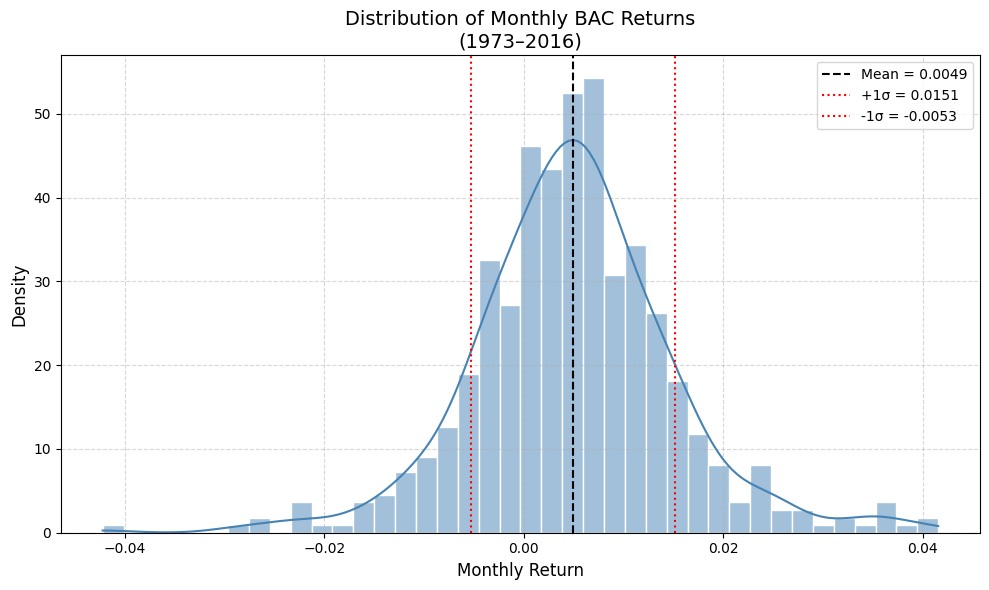

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

bac_df = bac_final.copy()
# Filter to paper's sample period
start_date = '1973-01-31'
end_date = '2016-12-31'

# Ensure datetime format
bac_df['month'] = pd.to_datetime(bac_df['month'])

# Filter
filtered = bac_df[(bac_df['month'] >= start_date) & (bac_df['month'] <= end_date)].copy()

# Compute stats
mean_ret = filtered['bac_return'].mean()
std_ret = filtered['bac_return'].std()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(filtered['bac_return'], kde=True, bins=40, color='steelblue', stat='density', edgecolor='white')

# Annotations
plt.axvline(mean_ret, color='black', linestyle='--', label=f"Mean = {mean_ret:.4f}")
plt.axvline(mean_ret + std_ret, color='red', linestyle=':', label=f"+1σ = {mean_ret + std_ret:.4f}")
plt.axvline(mean_ret - std_ret, color='red', linestyle=':', label=f"-1σ = {mean_ret - std_ret:.4f}")

# Labels and aesthetics
plt.title("Distribution of Monthly BAC Returns\n(1973–2016)", fontsize=14)
plt.xlabel("Monthly Return", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


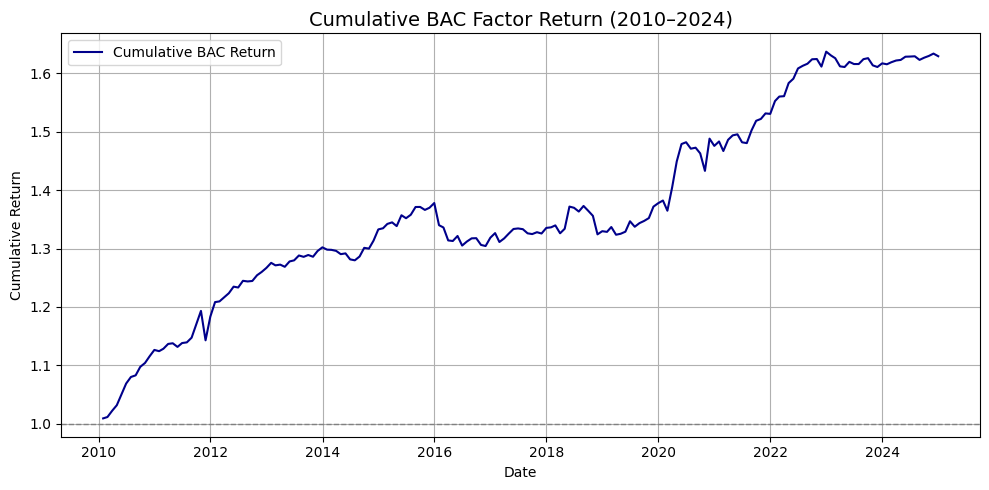

In [22]:
import matplotlib.pyplot as plt

# Filter BAC returns from 2010 onwards
bac_plot = bac_final[bac_final['month'] >= '2010-01-01'].copy()

# Compute cumulative returns
bac_plot['cum_return'] = (1 + bac_plot['bac_return']).cumprod()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(bac_plot['month'], bac_plot['cum_return'], label='Cumulative BAC Return', color='darkblue')
plt.axhline(1, color='gray', linestyle='--', linewidth=1)
plt.title("Cumulative BAC Factor Return (2010–2024)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
import numpy as np

df = pd.read_csv(r'/kaggle/input/daily-crsp-df/F-F_Research_Data_Factors.csv')

df['date'] = pd.to_datetime(df['date'], format='%Y%m')
df['date'] = df['date'] + pd.offsets.MonthEnd(0)


# --- 3. Convert percentages in numerical columns to decimals ---
# Identify numerical columns (excluding the 'Date' column)
# This assumes that ALL other numerical columns are percentages and need conversion.
# Adjust `exclude=['Date']` if you have other non-percentage columns.

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

if 'date' in numerical_cols:
    numerical_cols.remove('date') 

for col in numerical_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col] / 100
    else:
        print(f"Warning: Column '{col}' is not numeric and will not be converted.")




In [24]:
df

,date,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0289,-0.0255,-0.0239,0.0022
1,1926-08-31,0.0264,-0.0114,0.0381,0.0025
2,1926-09-30,0.0038,-0.0136,0.0005,0.0023
3,1926-10-31,-0.0327,-0.0014,0.0082,0.0032
4,1926-11-30,0.0254,-0.0011,-0.0061,0.0031
...,...,...,...,...,...
1180,2024-11-30,0.0649,0.0446,0.0016,0.0040
1181,2024-12-31,-0.0317,-0.0271,-0.0299,0.0037
1182,2025-01-31,0.0280,-0.0197,0.0163,0.0037
1183,2025-02-28,-0.0244,-0.0579,0.0491,0.0033


In [25]:
# Ensure date columns are datetime type
df['date'] = pd.to_datetime(df['date'])
bac_final['month'] = pd.to_datetime(bac_final['month'])

# Perform left join
merged = bac_final.merge(df, how='left', left_on='month', right_on='date')

# Drop the 'date' column and keep 'month' as the final date column
merged = merged.drop(columns=['date'])

# Display the result
merged.head()


,month,bac_return,Mkt-RF,SMB,HML,RF
0,1971-03-31,0.002636,0.0412,0.0260,-0.0395,0.0030
1,1971-04-30,-0.002013,0.0315,-0.0049,0.0086,0.0028
2,1971-05-31,-0.005592,-0.0399,-0.0104,-0.0133,0.0029
3,1971-06-30,-0.000236,-0.0009,-0.0153,-0.0197,0.0037
4,1971-07-31,-0.001598,-0.0449,-0.0151,-0.0002,0.0040


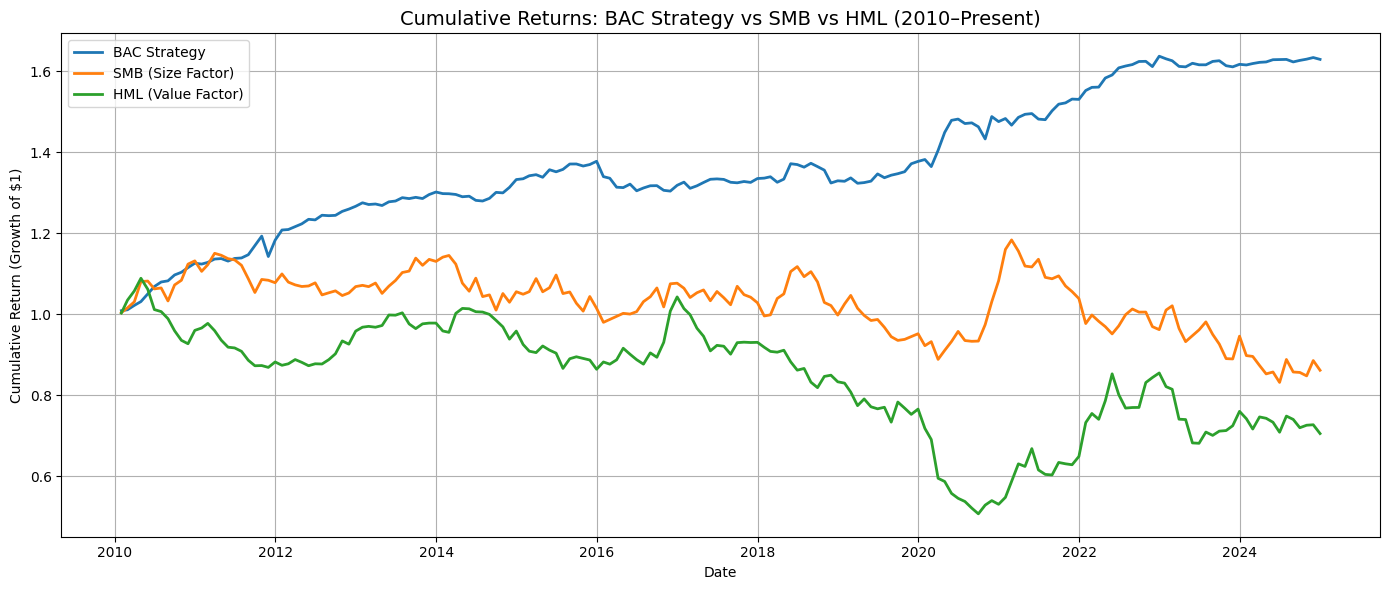

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'month' column is datetime
merged['month'] = pd.to_datetime(merged['month'])

# Filter data from 2010 onward
merged_2010 = merged[merged['month'] >= '2010-01-01'].copy()

# Compute cumulative returns
merged_2010['cum_bac'] = (1 + merged_2010['bac_return']).cumprod()
merged_2010['cum_SMB'] = (1 + merged_2010['SMB']).cumprod()
merged_2010['cum_HML'] = (1 + merged_2010['HML']).cumprod()


# Plotting
plt.figure(figsize=(14, 6))
plt.plot(merged_2010['month'], merged_2010['cum_bac'], label='BAC Strategy', linewidth=2)
plt.plot(merged_2010['month'], merged_2010['cum_SMB'], label='SMB (Size Factor)', linewidth=2)
plt.plot(merged_2010['month'], merged_2010['cum_HML'], label='HML (Value Factor)', linewidth=2)
plt.title('Cumulative Returns: BAC Strategy vs SMB vs HML (2010–Present)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Growth of $1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
merged['excess_bac'] = merged['bac_return'] - merged['RF']
import statsmodels.api as sm

df_reg = merged.dropna(subset=['excess_bac', 'Mkt-RF', 'SMB', 'HML'])

X = df_reg[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)  # add intercept (alpha)
y = df_reg['excess_bac']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             excess_bac   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     12.53
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           5.68e-08
Time:                        03:48:15   Log-Likelihood:                 2029.1
No. Observations:                 646   AIC:                            -4050.
Df Residuals:                     642   BIC:                            -4032.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.809      0.0

In [34]:
df = pd.read_parquet(r"/kaggle/input/daily-crsp-df/daily_df_crps_dump.parquet")
df

,permno,date,shrcd,exchcd,ret
19071,10006,1968-01-02,10.0,1.0,-0.019499
39051,10014,1968-01-02,10.0,1.0,0.100000
88928,10030,1968-01-02,10.0,1.0,0.004348
166601,10057,1968-01-02,11.0,1.0,0.000000
296155,10102,1968-01-02,10.0,1.0,-0.003610
...,...,...,...,...,...
95720509,93374,2024-12-31,11.0,1.0,0.005475
95765765,93397,2024-12-31,11.0,3.0,0.016625
95824963,93426,2024-12-31,11.0,1.0,0.010331
95841141,93434,2024-12-31,11.0,3.0,-0.052195
